In [1]:
import torch
from torch import nn

In [2]:
from typing import List

class MLP(nn.Module):
  def __init__(self, layers: List):
    super().__init__()

    self.weights = []
    self.bias = []

    for i in range(len(layers)-1):
      self.weights.append(torch.randn((layers[i], layers[i+1])))
      self.bias.append(torch.randn(()))

    self.weights = nn.ParameterList(self.weights)
    self.bias = nn.ParameterList(self.bias)
  def forward(self, X):
    for i in range(len(self.bias)):
      X = X @ self.weights[i] + self.bias[i]
    return X

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(100, 16, random_state=42)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(torch.Tensor(X), torch.Tensor(y), test_size=0.2, random_state=42)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = MLP([16, 32, 64, 32, 4, 1]).to(device)

def mse(y_true, y_pred):
  return torch.mean(torch.square(y_true - y_pred), axis=0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = mse
epochs = 10000

results = {'train': [], 'test': []}

for epoch in range(epochs):
  model.train()
  y_pred = model(X_train.to(device))
  optimizer.zero_grad()
  loss = mse(y_train.to(device), y_pred)
  loss.backward()
  optimizer.step()
  results['train'].append(loss.item())

  with torch.no_grad():
    model.eval()
    y_pred = model(X_test.to(device))
    loss = mse(y_test.to(device), y_pred)
    results['test'].append(loss.item())
    if epoch % 1000 == 0:
      print(f'{epoch}/{epochs} | loss: {loss.item()}')

0/10000 | loss: 5926017.0
1000/10000 | loss: 28678.615234375
2000/10000 | loss: 10187.4814453125
3000/10000 | loss: 2314.198974609375
4000/10000 | loss: 171.0224151611328
5000/10000 | loss: 1.3874528408050537
6000/10000 | loss: 0.0009402299183420837
7000/10000 | loss: 7.953208296385128e-06
8000/10000 | loss: 5.692430704584694e-07
9000/10000 | loss: 1.5557289145817776e-07


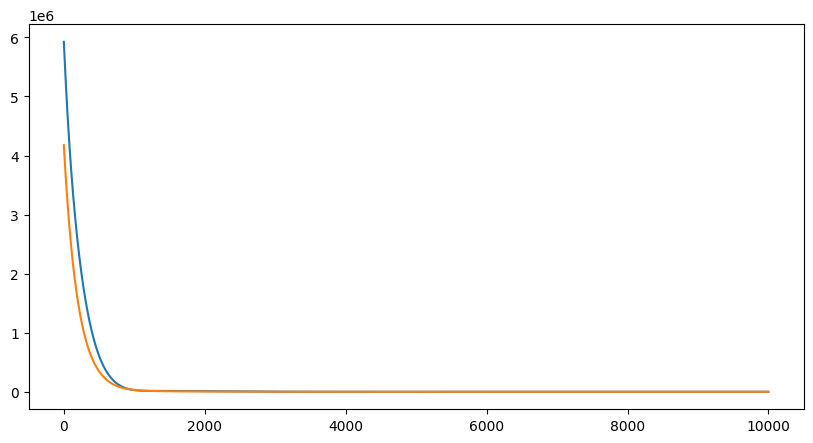

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(results['test'])), results['test'], label='Validation Loss')
plt.plot(range(len(results['train'])), results['train'], label='Train Loss')